##Librerias

In [1]:
!pip install scikit-learn
!pip install collections
%pip install imblearn.over_sampling
%pip install mlflow


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement imblearn.over_sampling (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
ERROR: No matching distribution found for imblearn.over_sampling
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import gaussian_kde
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import datetime
import os
import mlflow
import sklearn

##dataset

Montamos Google Drive y cargamos el dataset del banco que contiene la información de la campaña de marketing.

Si la carpeta del proyecto no se encuentra en google drive, se recomienda subir el archivo de datos en el google colab, o escribir la ruta del archivo en el que se encuentre si se emplea otro entorno de ejecución del código.

In [ ]:
csv_path = '/workspaces/deteccion_clientes_banco/data/bank-additional-full.csv' # comentar el que no se use
#csv_path = '/content/bank-additional-full.csv' # comentar el que no se use
data = pd.read_csv(csv_path, sep=";")

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/deteccion_clientes_banco/data/bank-additional-full.cs'

##Análisis exploratorio de los datos

In [ ]:
columnas = data.columns
estructura = data.shape
print("La cantidad de observaciones es: ", estructura[0])
print("La cantidad de variables es: ", estructura[1])
print("Estas variables son: ", columnas)

La cantidad de observaciones es:  41188
La cantidad de variables es:  21
Estas variables son:  Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [ ]:
data.dtypes.to_frame()

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


*  (int) **Age**: Edad del cliente.
*  (Category) **Job**: Tipo de trabajo.
*  (Category) **Marital**: estado civil.
*  (Category) **Education**: Nivel de educación del cliente.
*  (Category) **Default**: Si tiene crédito en mora. Si no realizó pagos de deudas que poseía.
*  (Category) **Housing**: Si tiene préstamo de vivienda.
*  (Category) **Loan**: Si tiene préstamo personal.
*  (Category) **Contact**: Tipo de comunicación de contacto.
*  (Category) **Month**: último día de contacto del mes.
*  (Category) **Day of the week**: Último mes de contacto del año.
*  (int)      **Duration**: Duración del último contacto, en segundos.
*  (int)      **Campaign**: Número de contactos realizados durante esta campaña y para este cliente.
*  (int)      **Pdays**: Número de días que pasaron después de que el cliente fue contactado por última vez de una campaña anterior.
*  (int)      **Previous**: Número de contactos realizados antes de esta campaña y para este cliente.
*  (Category) **Poutcome**: Resultado de la campaña de marketing anterior.
*  (float)   **emp.var.rate**: .
*  (float)    **cons.price.idx**: .
*  (float)    **cons.conf.idx**: .
*  (float)    **euribor3m**: .
*  (float)    **nr.employed**: .
*  (Category) **Y**: El cliente ha suscrito un depósito a plazo o no.      



In [ ]:
data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15469,45,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
21008,39,management,married,university.degree,no,yes,no,cellular,aug,thu,...,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
36994,33,admin.,single,university.degree,no,no,no,cellular,jul,fri,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.059,5076.2,yes
29168,22,admin.,married,high.school,no,yes,yes,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
9281,36,blue-collar,married,basic.6y,no,unknown,unknown,telephone,jun,fri,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no


---

# Exploración

Balanceo de la variable objetivo "y"

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


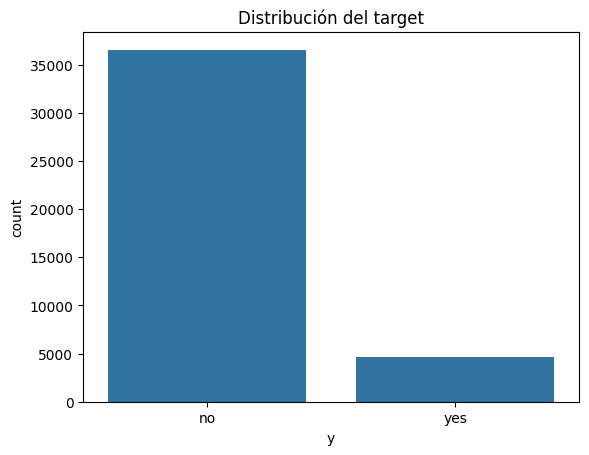

In [ ]:
print(data['y'].value_counts(normalize=True))

sns.countplot(data=data, x='y')
plt.title("Distribución del target")
plt.show()

Distribución variables numericas

Análisis de "pdays"
Valores con 999: 39.500

In [ ]:
data["pdays"].value_counts().head()

,count
pdays,
999,39673
3,439
6,412
4,118
9,64


(41188,)
(1515,)


<Axes: >

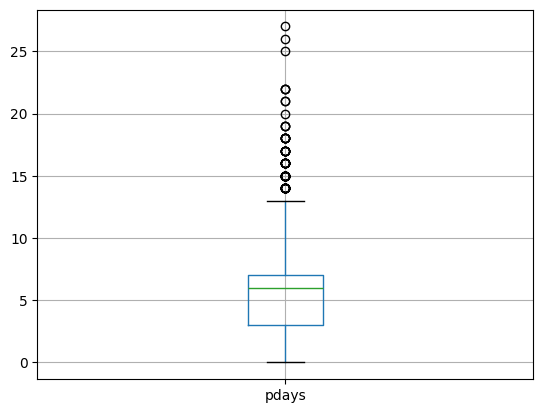

In [ ]:
pdays2 = data[data["pdays"] != 999]
print(data["pdays"].shape)
print(pdays2["pdays"].shape)
pdays2.boxplot("pdays")

<Axes: >

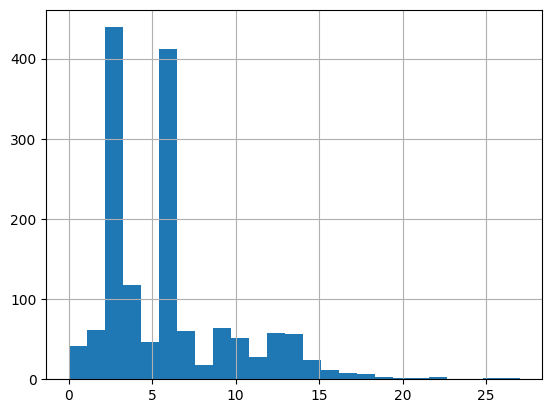

In [ ]:
pdays2["pdays"].hist(bins=25)

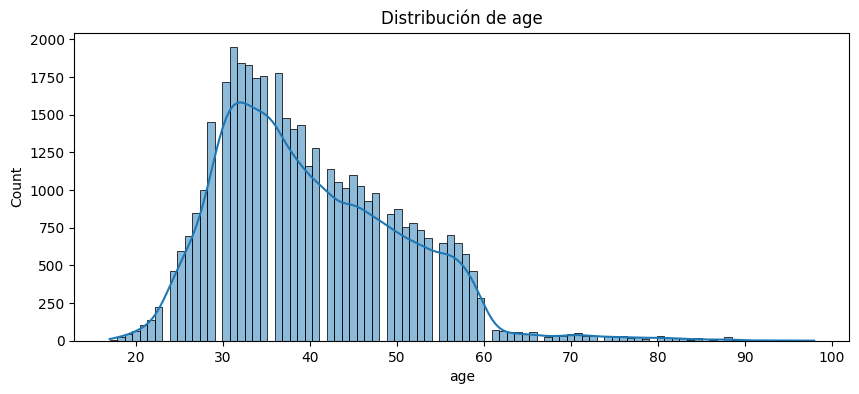

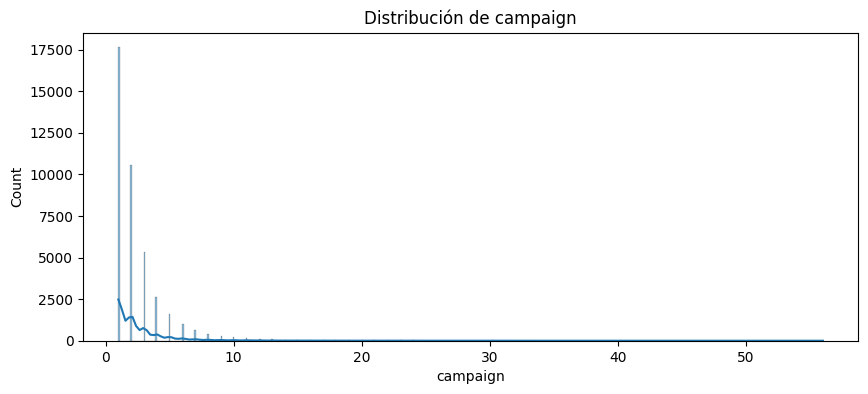

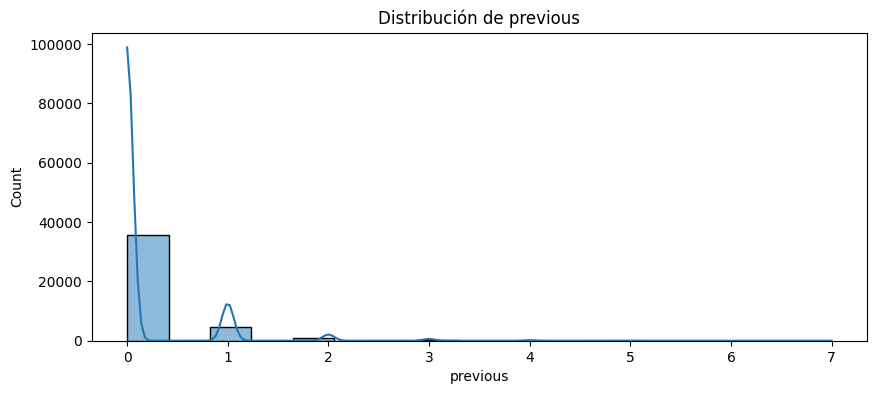

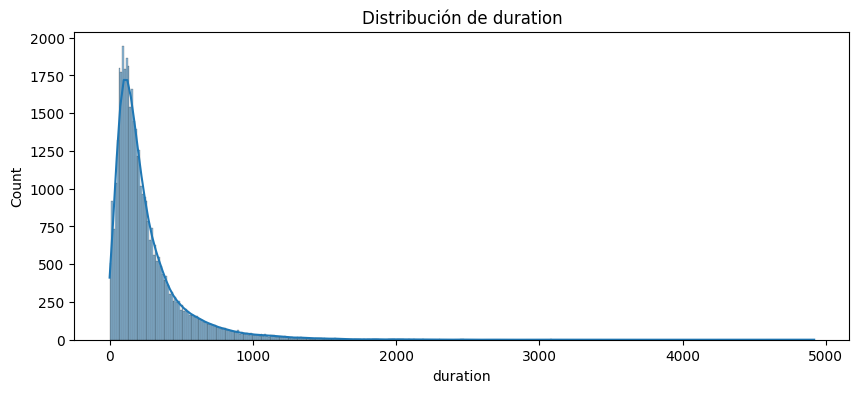

In [ ]:
num_vars = ['age', 'campaign', 'previous', 'duration']

for col in num_vars:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


distribucion variables categoricas

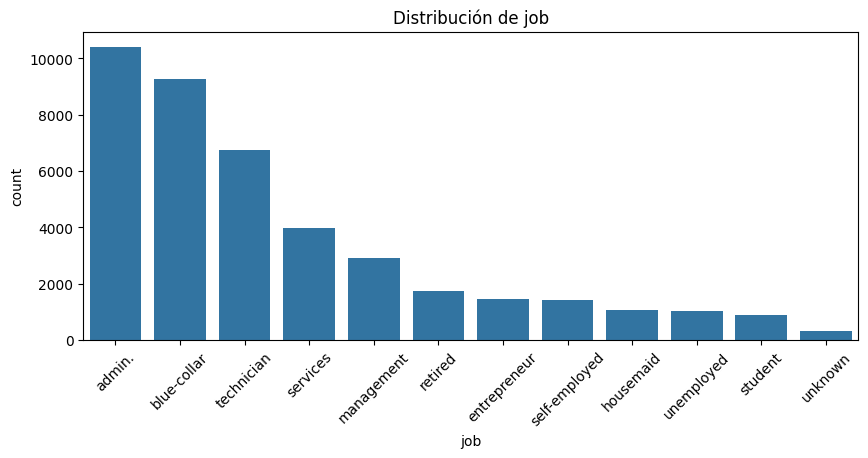

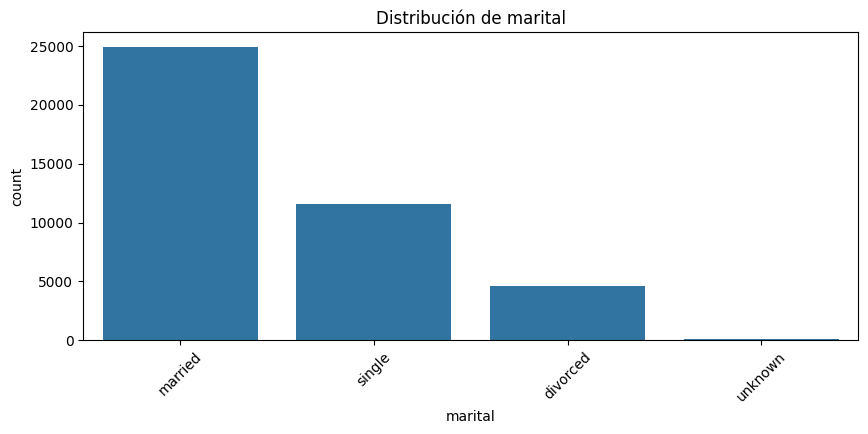

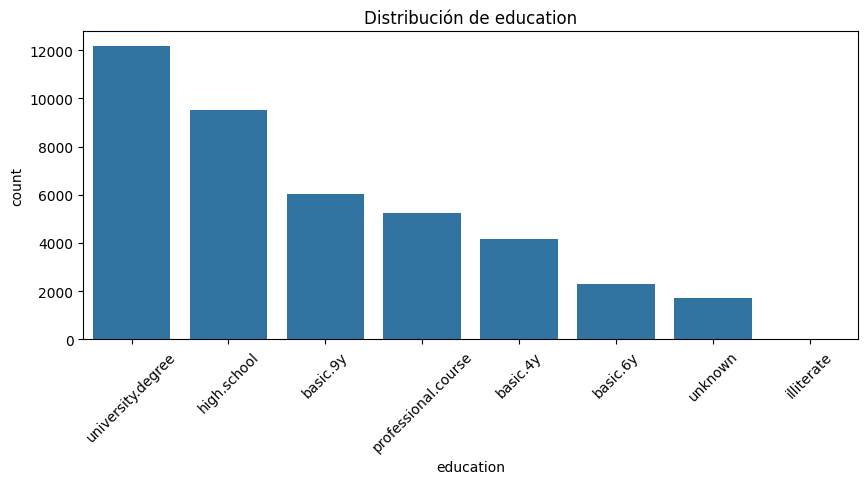

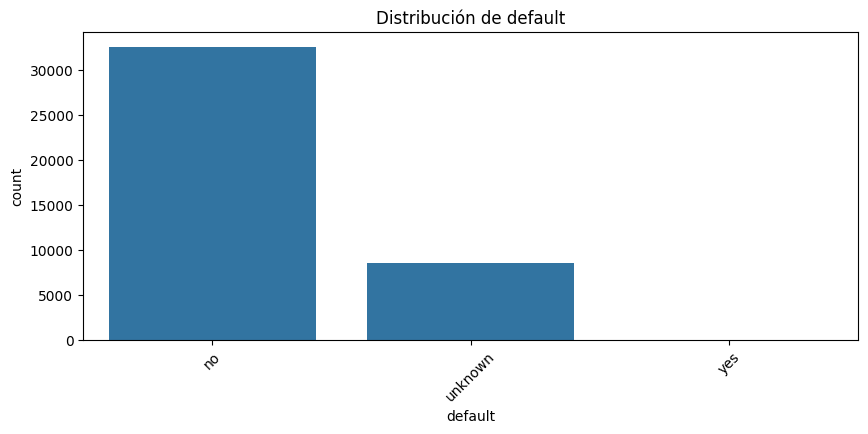

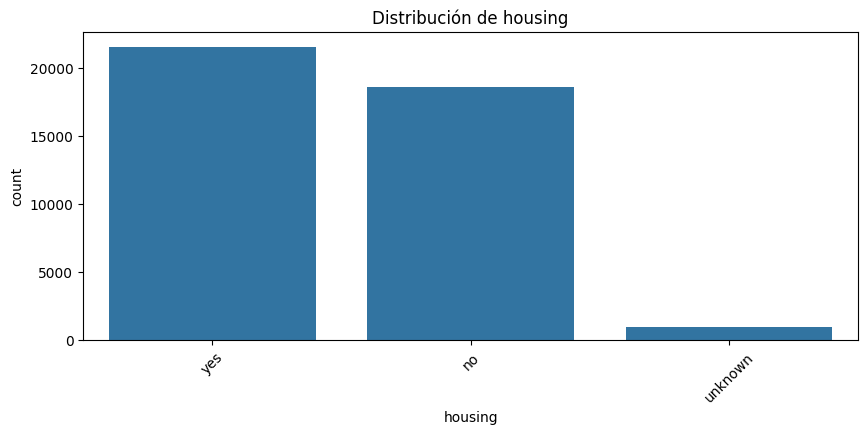

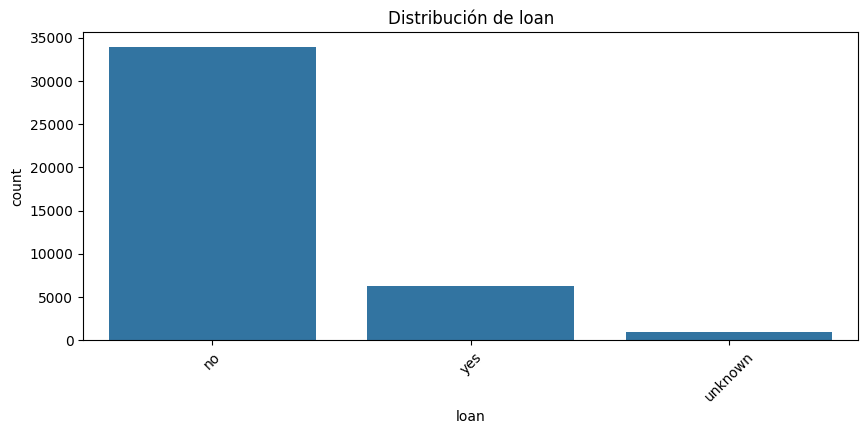

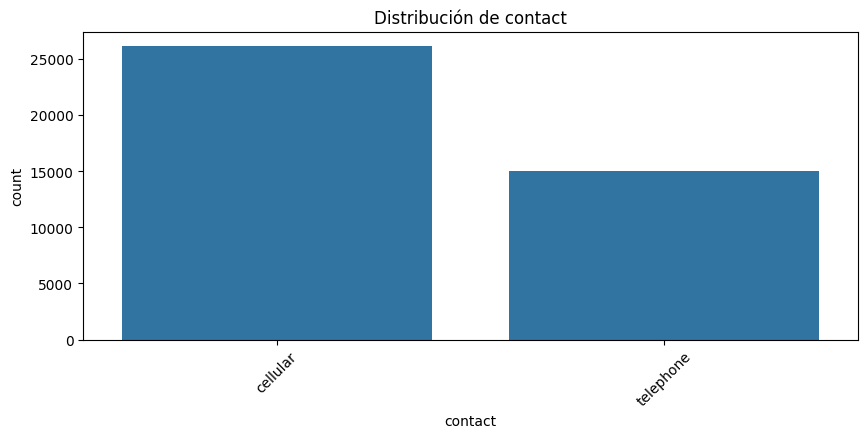

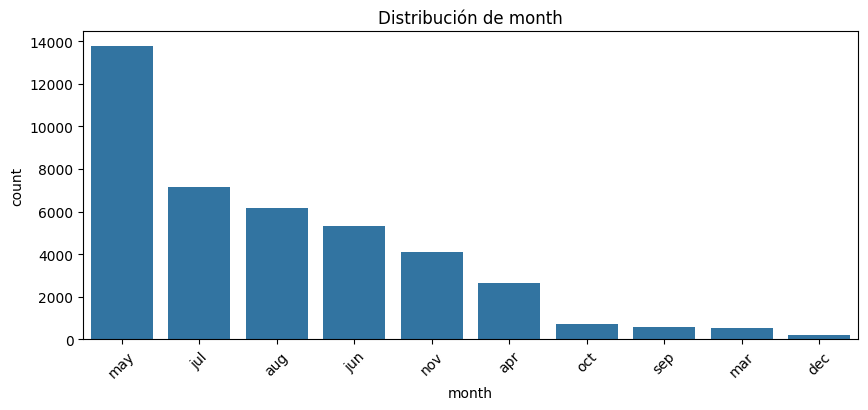

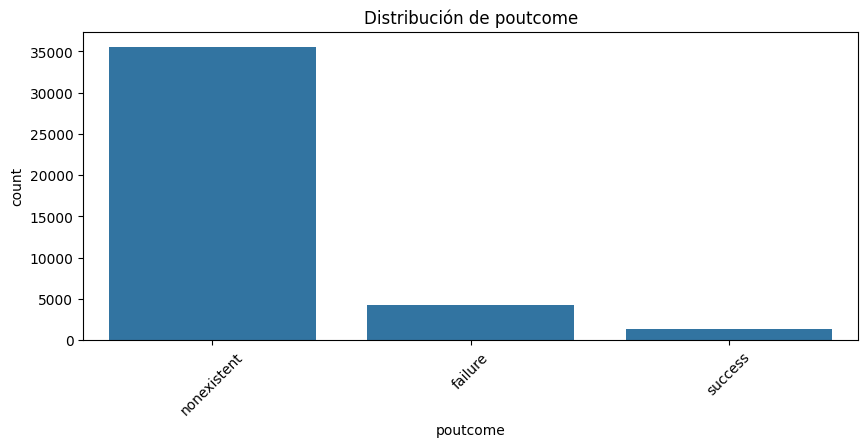

In [ ]:
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in cat_vars:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribución de {col}')
    plt.show()

boxplots para ver variables con outliers

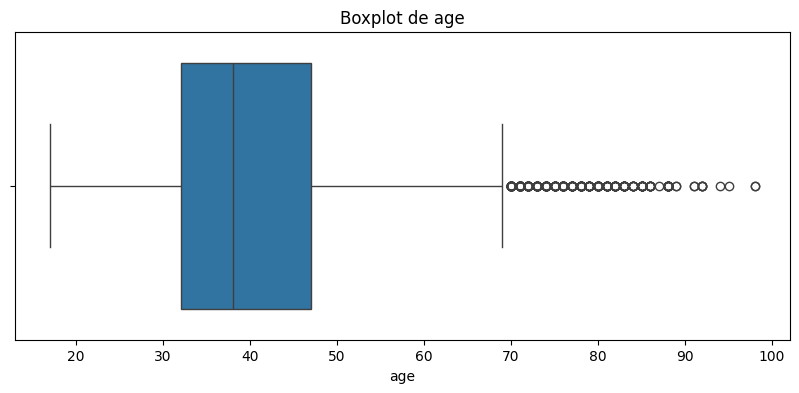

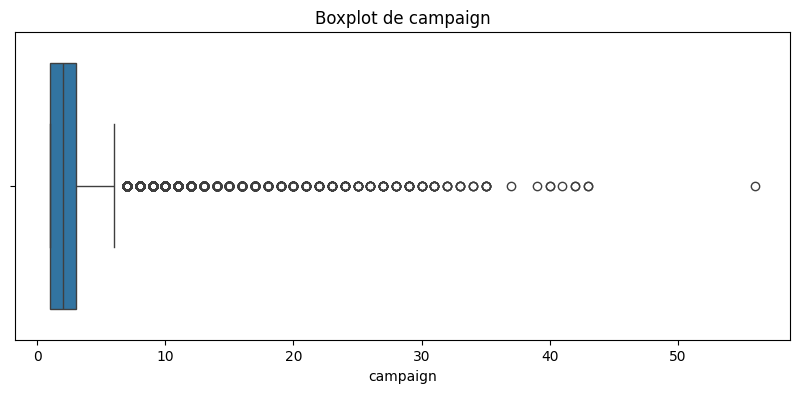

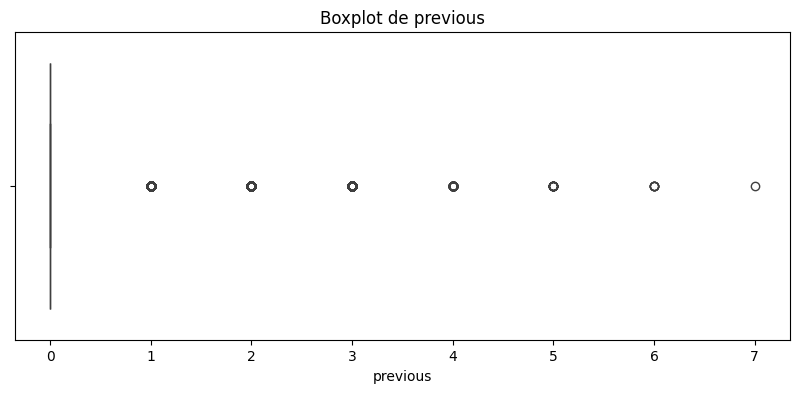

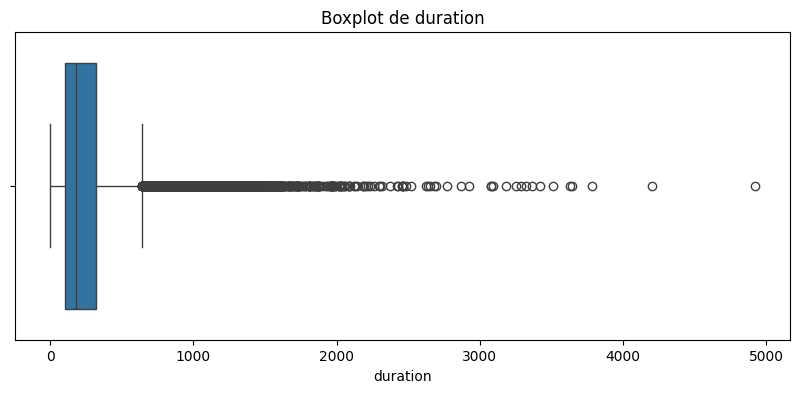

In [ ]:
for col in num_vars:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

---

# Procesamiento

## Datos Faltantes

In [ ]:
print("La cantidad de NaNs por variable es: ")
print(data.isnull().sum())

La cantidad de NaNs por variable es: 
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


---

### Pocos NaNs

In [ ]:
data["duration"]

,duration
0,261
1,149
2,226
3,151
4,307
...,...
41183,334
41184,383
41185,189
41186,442


In [ ]:
data["marital"].value_counts()

,count
marital,
married,24928
single,11568
divorced,4612
unknown,80


In [ ]:
data['job'].value_counts()

,count
job,
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060


In [ ]:
data["day_of_week"].value_counts()

,count
day_of_week,
thu,8623
mon,8514
wed,8134
tue,8090
fri,7827


In [ ]:
data["contact"].value_counts()

,count
contact,
cellular,26144
telephone,15044


---

In [ ]:
data['housing'].value_counts()


,count
housing,
yes,21576
no,18622
unknown,990


In [ ]:
data["loan"].value_counts()

,count
loan,
no,33950
yes,6248
unknown,990


Los valores donde Housing es unknown, Loan tambien lo es.

In [ ]:
data[(data["loan"] == "unknown")&(data["housing"] == "unknown")].shape

(990, 21)

---

In [ ]:
data["month"].value_counts()

,count
month,
may,13769
jul,7174
aug,6178
jun,5318
nov,4101
apr,2632
oct,718
sep,570
mar,546


---

In [ ]:
data["previous"].value_counts()

,count
previous,
0,35563
1,4561
2,754
3,216
4,70
5,18
6,5
7,1


### Analizar PDAYS

In [ ]:
data["pdays"].value_counts()

,count
pdays,
999,39673
3,439
6,412
4,118
9,64
2,61
7,60
12,58
10,52


In [ ]:
print(f"No fueron contactados (999):", data[data["pdays"]== 999].shape)
print(f"Fueron contactados:", data[data["pdays"] != 999].shape)

No fueron contactados (999): (39673, 21)
Fueron contactados: (1515, 21)


In [ ]:
# Casos con pdays == 999 (no fue contactado) y previous > 0 (tuvo contactos)
data[(data['pdays'] == 999) & (data['previous'] > 0)].shape
# Elimino inconsistensias
data = data.drop(data[(data['pdays'] == 999) & (data['previous'] > 0)].index)

---

### Varios NaNs

In [ ]:
data["poutcome"].value_counts()

,count
poutcome,
nonexistent,35563
success,1373
failure,142


Variable no servible¿

In [ ]:
data["default"].value_counts()

,count
default,
no,28990
unknown,8086
yes,2


## Valores Atípicos

In [4]:
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (serie < lower_bound) | (serie > upper_bound)


In [ ]:
num_vars = ['age', 'campaign', 'previous', 'duration']
data_outliers = data.copy()
for variable in num_vars:
    outliers_mask = detectar_outliers_iqr(data[variable])
    data_outliers[f'is_outlier_{variable}'] = outliers_mask
    outliers = data[variable][outliers_mask]
    print(f"Cantidad de outliers en {variable}:", len(outliers))
    #Identificar porcentaje de estas cantidades en el df
    print(f"Porcentaje de outliers en {variable}:", (len(outliers)/len(data[variable]))*100)

NameError: name 'data' is not defined

Desición tomada: marcar observaciones que tenga (al menos) una variable con un valor outlier como una observación con outlier. Luego, se realizará la eliminación de las observaciones marcadas.

### Marcado de valores atípicos

In [ ]:
# drop columnas con is_outliers False en todas las observaciones
cols = ["is_outlier_euribor3m", "is_outlier_nr.employed", "is_outlier_emp.var.rate", "is_outlier_cons.price.idx"]
if all(col in data_outliers.columns for col in cols):
    data_outliers = data_outliers.drop(columns = ["is_outlier_euribor3m", "is_outlier_nr.employed", "is_outlier_emp.var.rate", "is_outlier_cons.price.idx"])
# Crear columna is_outlier con la condicion: is_outliers_age == True or is_outlier_campaign == True or is_outlier_pdays ==True or is_outlier_previous == True or is_outliers_duration ==True or is_outlier_cons.conf.idx ==True

cols_2 = ['is_outlier_age', 'is_outlier_campaign', 'is_outlier_pdays',
        'is_outlier_previous', 'is_outlier_duration', 'is_outlier_cons.conf.idx']

# Filtramos solo las columnas que realmente están en el DataFrame
existing_cols = [col for col in cols_2 if col in data_outliers.columns]

# Aplicamos .any() solo sobre esas columnas
data_outliers['is_outlier'] = data_outliers[existing_cols].any(axis=1)


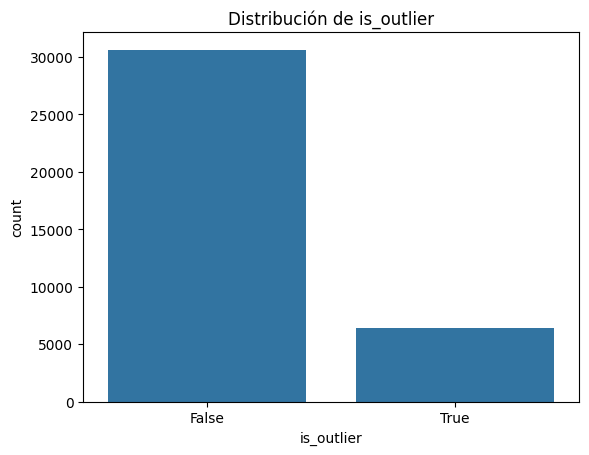

In [ ]:
#agregar la columna is_outlier a data
data['is_outlier'] = data_outliers['is_outlier']
#ver distribución de data_outliers.is_outlier
sns.countplot(data=data, x='is_outlier')
plt.title("Distribución de is_outlier")
plt.show()

In [ ]:
print("Edad mínima:", data['age'].min())
print("Edad máxima:", data['age'].max())

Edad mínima: 17
Edad máxima: 98


Cuando la duración del último contacto fue 0, también tuvo 0 contactos (previous) y no fue contactado (pdays)

In [ ]:
data[(data["duration"] == 0)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_outlier
6251,39,admin.,married,high.school,no,yes,no,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,False
23031,59,management,married,university.degree,no,yes,no,cellular,aug,tue,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no,True
28063,53,blue-collar,divorced,high.school,no,yes,no,cellular,apr,fri,...,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no,False
33015,31,blue-collar,married,basic.9y,no,no,no,cellular,may,mon,...,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no,False


In [ ]:
# Duplicados
print("Duplicados exactos:", data.duplicated().sum())
data[data.duplicated()].shape

Duplicados exactos: 12


(12, 22)

### Eliminación de valores atípicos

In [ ]:
def remove_outliers_iqr(df):
    df_no_outliers = df.copy()
    numeric_cols = df_no_outliers.select_dtypes(include=np.number).columns # Filter for numeric columns only
    for col in numeric_cols: # Iterate over numeric columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers


data = remove_outliers_iqr(data)

# Feature engineering

## Feature construction

In [ ]:
# Total de contactos
data['contactosTotales'] = data['campaign'] + data['previous']


# Campañas exitosas previas
data['campañasExitosasPrevias'] = ((data['poutcome'] == 'success') & (data['previous'] > 0)).astype(int)
data["campañasExitosasPrevias"]

,campañasExitosasPrevias
0,0
1,0
2,0
3,0
4,0
...,...
41183,0
41184,0
41185,0
41186,0


## Feature improvenment

### Codificación de variables categóricas

In [ ]:
encode = data.copy()
encode.drop(columns=['is_outlier', 'default',"poutcome"], inplace=True)
encode.dtypes.to_frame()

,0
age,int64
job,object
marital,object
education,object
housing,object
loan,object
contact,object
month,object
day_of_week,object
duration,int64


In [ ]:
encode.sample(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contactosTotales,campañasExitosasPrevias
33464,47,blue-collar,married,basic.9y,no,no,cellular,may,tue,118,...,999,1,-1.8,92.893,-46.2,1.291,5099.1,no,3,0
19158,35,admin.,married,university.degree,yes,no,cellular,aug,tue,385,...,999,0,1.4,93.444,-36.1,4.968,5228.1,no,3,0
10996,41,admin.,married,university.degree,yes,yes,telephone,jun,wed,802,...,999,0,1.4,94.465,-41.8,4.962,5228.1,no,3,0
38992,54,technician,divorced,university.degree,unknown,unknown,cellular,dec,mon,164,...,999,0,-3.0,92.713,-33.0,0.717,5023.5,no,1,0
6277,36,unemployed,single,basic.4y,yes,no,telephone,may,tue,267,...,999,0,1.1,93.994,-36.4,4.857,5191.0,no,1,0


target

In [ ]:
encode['y'] = encode['y'].astype(str)
encode['y'] = encode['y'].map({'no': 0, 'yes': 1})

occupation

In [ ]:
categorical_cols = encode.select_dtypes(include=['object']).columns
cardinality = {}
for col in categorical_cols:
    cardinality[col] = encode[col].nunique()


for col, card in cardinality.items():
    print(f"{col}: {card}")


job: 12
marital: 4
education: 8
housing: 3
loan: 3
contact: 2
month: 10
day_of_week: 5


In [ ]:
encode["previous"].value_counts()

,count
previous,
0,35563
1,4561
2,754
3,216
4,70
5,18
6,5
7,1


Job

In [ ]:
job_target_mean = encode.groupby('job')['y'].mean()
encode['job_target_mean'] = encode['job'].map(job_target_mean)


encode.drop('job', axis=1, inplace=True)
encode.head()

,age,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean
0,56,married,basic.4y,no,no,telephone,may,mon,261,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.100000
1,57,married,high.school,no,no,telephone,may,mon,149,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081381
2,37,married,high.school,yes,no,telephone,may,mon,226,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081381
3,40,married,basic.6y,no,no,telephone,may,mon,151,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.129726
4,56,married,high.school,no,yes,telephone,may,mon,307,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081381


Marital

In [ ]:
marital_dummies = pd.get_dummies(encode['marital'], prefix='marital', dtype=int)
encode = pd.concat([encode, marital_dummies], axis=1)
encode.drop('marital', axis=1, inplace=True)
encode.head()

,age,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,...,nr.employed,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean,marital_divorced,marital_married,marital_single,marital_unknown
0,56,basic.4y,no,no,telephone,may,mon,261,1,999,...,5191.0,0,1,0,0,0.100000,0,1,0,0
1,57,high.school,no,no,telephone,may,mon,149,1,999,...,5191.0,0,1,0,0,0.081381,0,1,0,0
2,37,high.school,yes,no,telephone,may,mon,226,1,999,...,5191.0,0,1,0,0,0.081381,0,1,0,0
3,40,basic.6y,no,no,telephone,may,mon,151,1,999,...,5191.0,0,1,0,0,0.129726,0,1,0,0
4,56,high.school,no,yes,telephone,may,mon,307,1,999,...,5191.0,0,1,0,0,0.081381,0,1,0,0


Education

In [ ]:
education_counts = encode['education'].value_counts(normalize=True)
encode['education_freq_encode'] = encode['education'].map(education_counts)
encode.drop('education', axis=1, inplace=True)
encode.head()

,age,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,...,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean,marital_divorced,marital_married,marital_single,marital_unknown,education_freq_encode
0,56,no,no,telephone,may,mon,261,1,999,0,...,0,1,0,0,0.100000,0,1,0,0,0.101389
1,57,no,no,telephone,may,mon,149,1,999,0,...,0,1,0,0,0.081381,0,1,0,0,0.231014
2,37,yes,no,telephone,may,mon,226,1,999,0,...,0,1,0,0,0.081381,0,1,0,0,0.231014
3,40,no,no,telephone,may,mon,151,1,999,0,...,0,1,0,0,0.129726,0,1,0,0,0.055647
4,56,no,yes,telephone,may,mon,307,1,999,0,...,0,1,0,0,0.081381,0,1,0,0,0.231014


Housing, Loan y Contact

In [ ]:
housing_dummies = pd.get_dummies(encode['housing'], prefix='housing', dtype=int)
loan_dummies = pd.get_dummies(encode['loan'], prefix='loan', dtype=int)
contact_dummies = pd.get_dummies(encode['contact'], prefix='contact', dtype=int)

encode = pd.concat([encode, housing_dummies, loan_dummies, contact_dummies], axis=1)

encode.drop(['housing', 'loan', 'contact'], axis=1, inplace=True)

encode.head()


,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,marital_unknown,education_freq_encode,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone
0,56,may,mon,261,1,999,0,1.1,93.994,-36.4,...,0,0.101389,1,0,0,1,0,0,0,1
1,57,may,mon,149,1,999,0,1.1,93.994,-36.4,...,0,0.231014,1,0,0,1,0,0,0,1
2,37,may,mon,226,1,999,0,1.1,93.994,-36.4,...,0,0.231014,0,0,1,1,0,0,0,1
3,40,may,mon,151,1,999,0,1.1,93.994,-36.4,...,0,0.055647,1,0,0,1,0,0,0,1
4,56,may,mon,307,1,999,0,1.1,93.994,-36.4,...,0,0.231014,1,0,0,0,0,1,0,1


Month y Day of Week

In [ ]:
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
encode['month'] = encode['month'].map(month_mapping)


day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
encode['day_of_week'] = encode['day_of_week'].map(day_mapping)


### Discretización de variables

 previous

In [ ]:
#Binning de previous
encode['previous_bin'] = pd.cut(data['previous'], bins=[-1, 0, 2, np.inf], labels=[0, 1, 2])
encode["previous_bin"] = encode["previous_bin"].astype(int)
encode["previous_bin"].value_counts()
# 0: Nada (0 contactos)
# 1: Poco (1 o 2 contactos)
# 2: Mucho (3-7)

,count
previous_bin,
0,35563
1,5315
2,310


# Análisis de Correlación

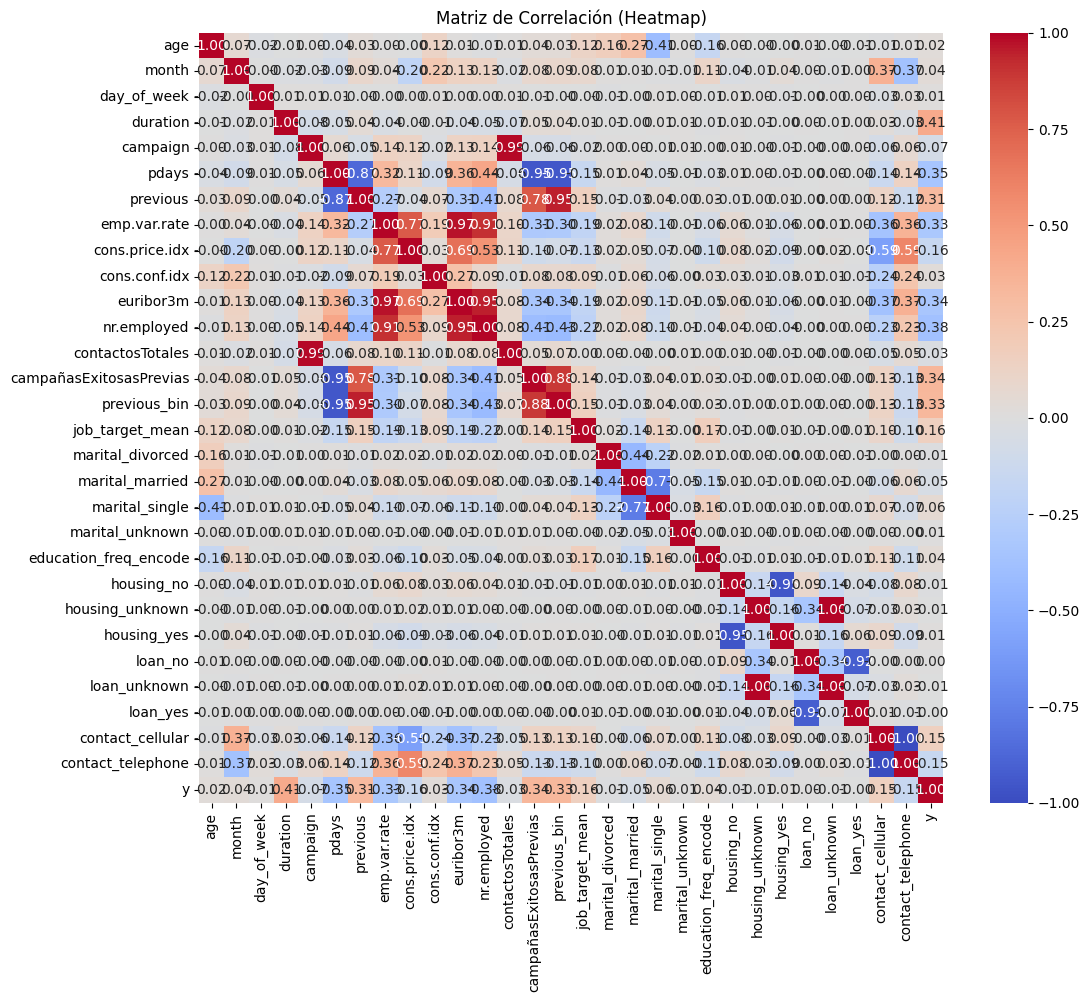

In [ ]:
numericas = encode.select_dtypes(include=['int64', 'float64']).columns
numericas = numericas.drop('y')
numericas = encode[numericas.tolist()  + ['y']] # para que quede y al final|


correlation_matrix = numericas.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación (Heatmap)')
plt.show()


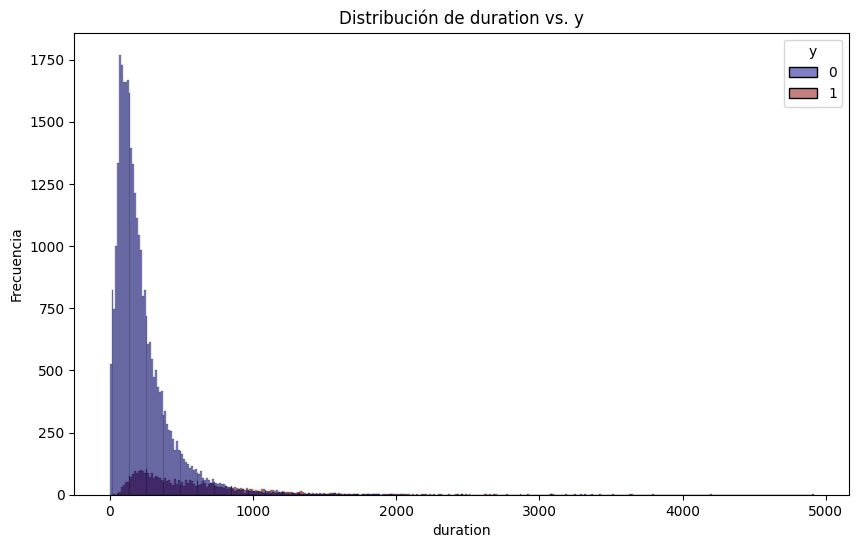

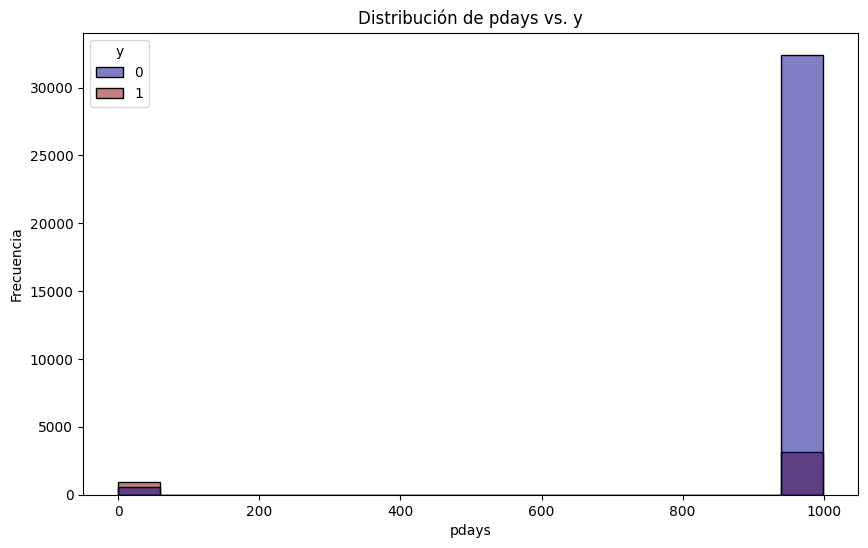

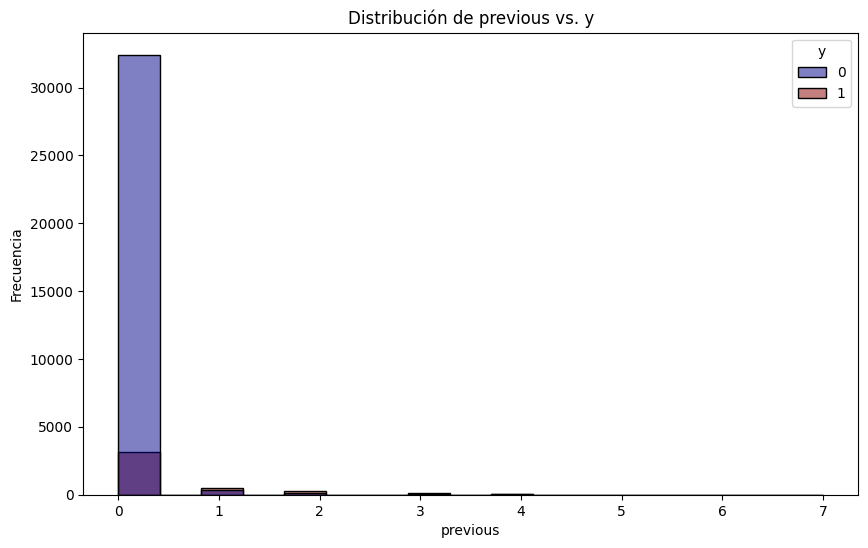

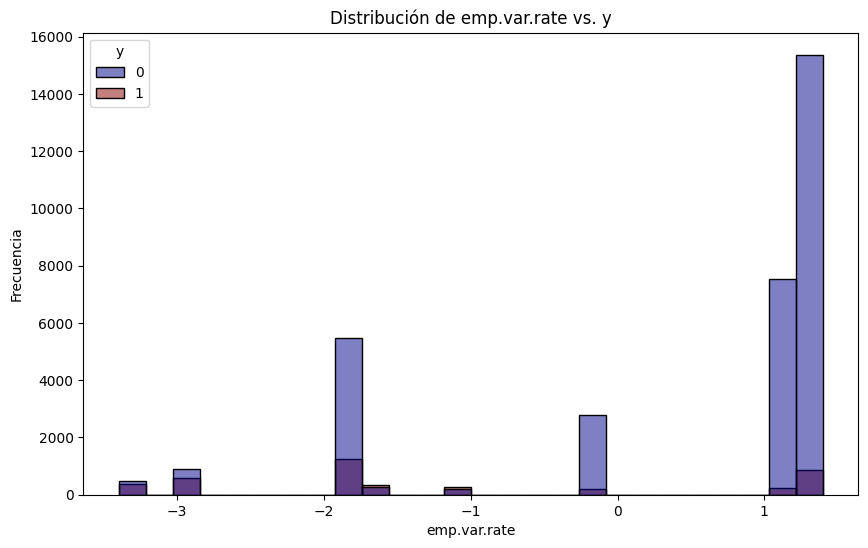

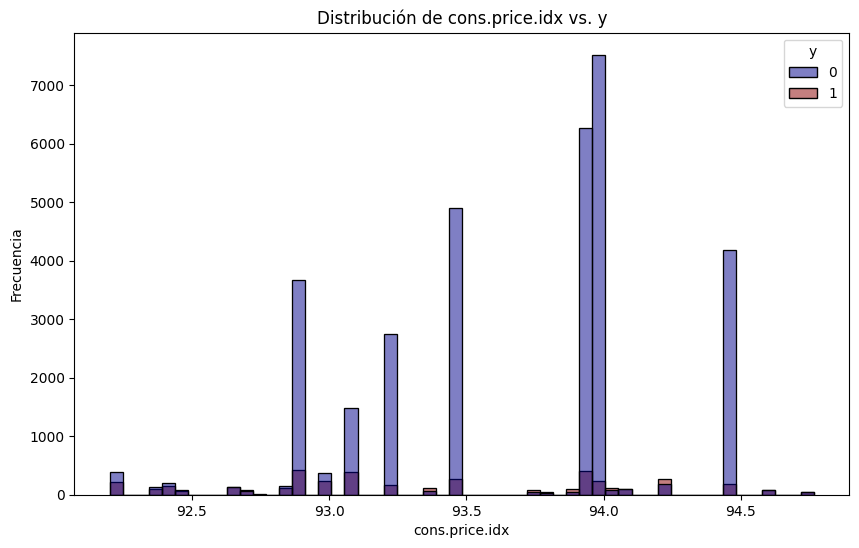

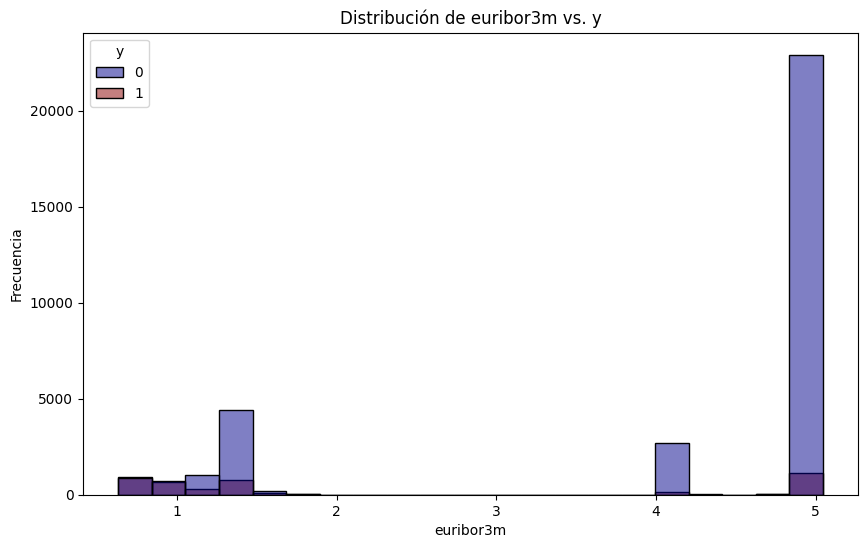

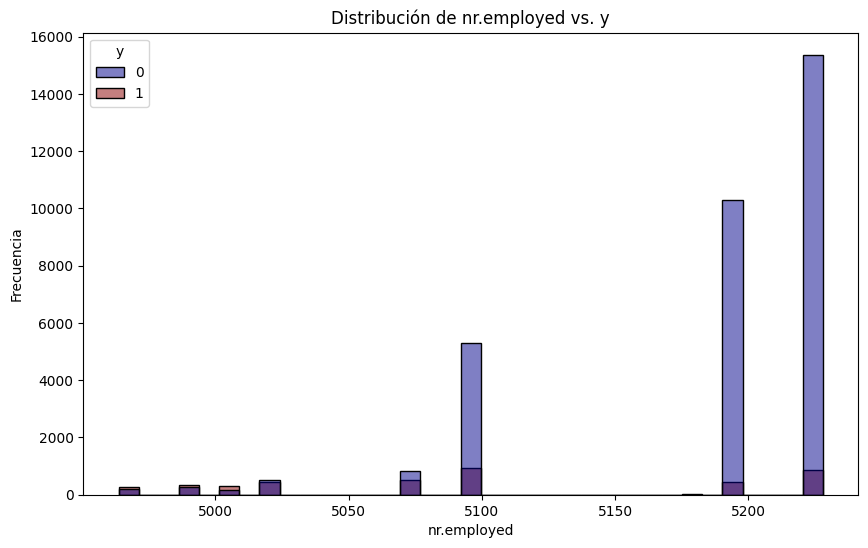

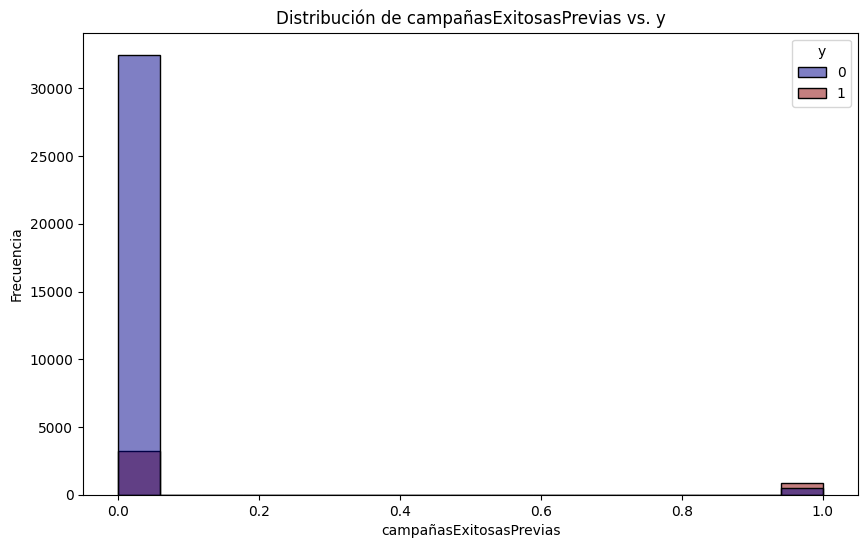

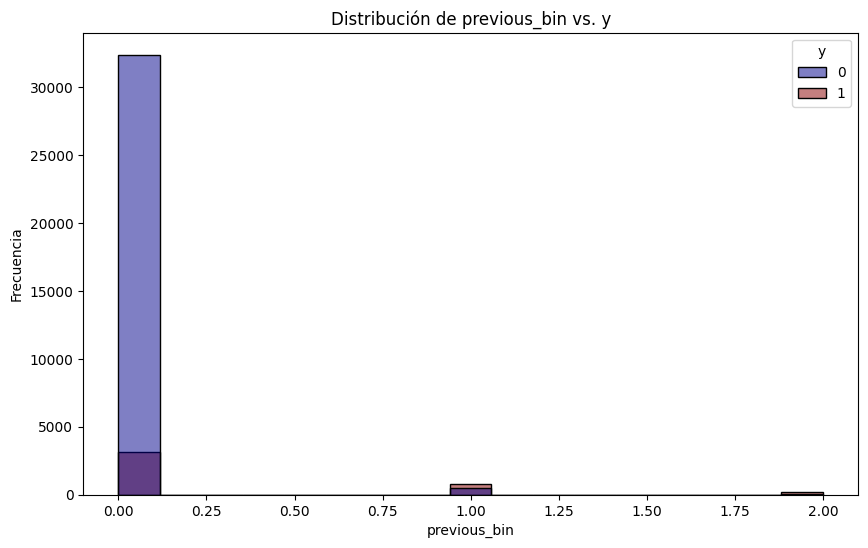

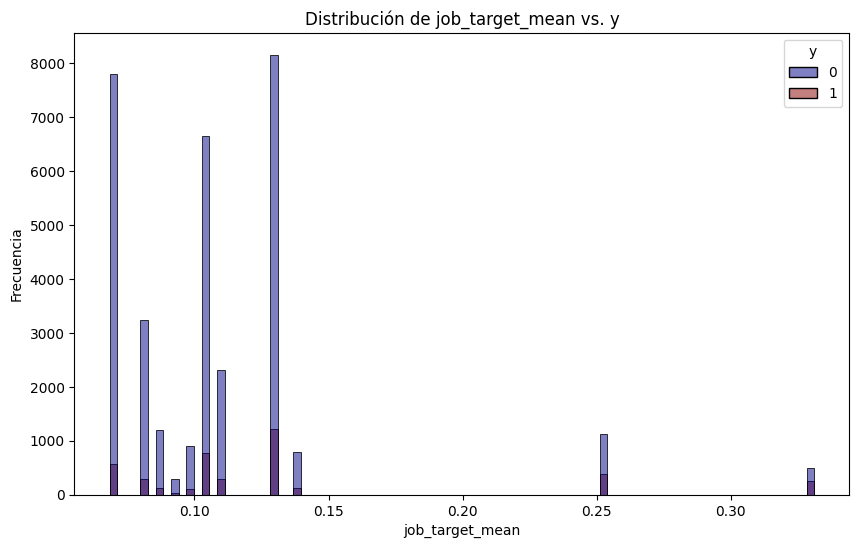

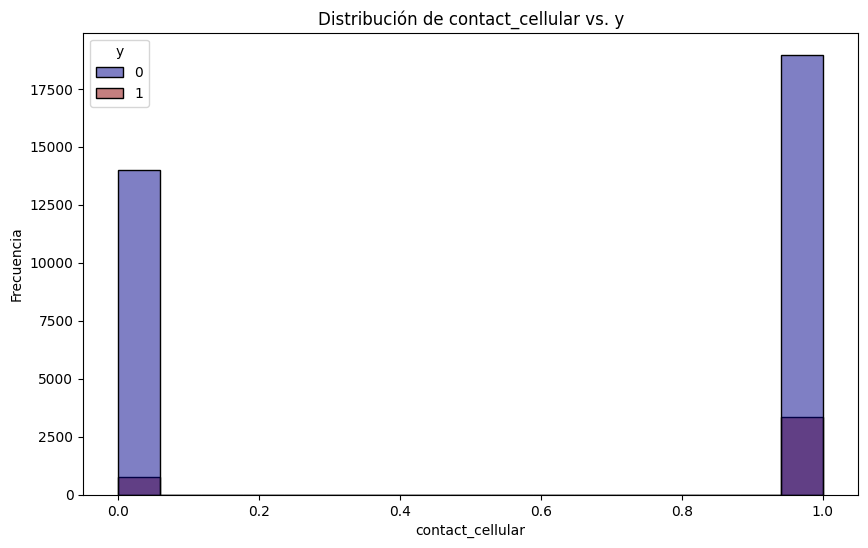

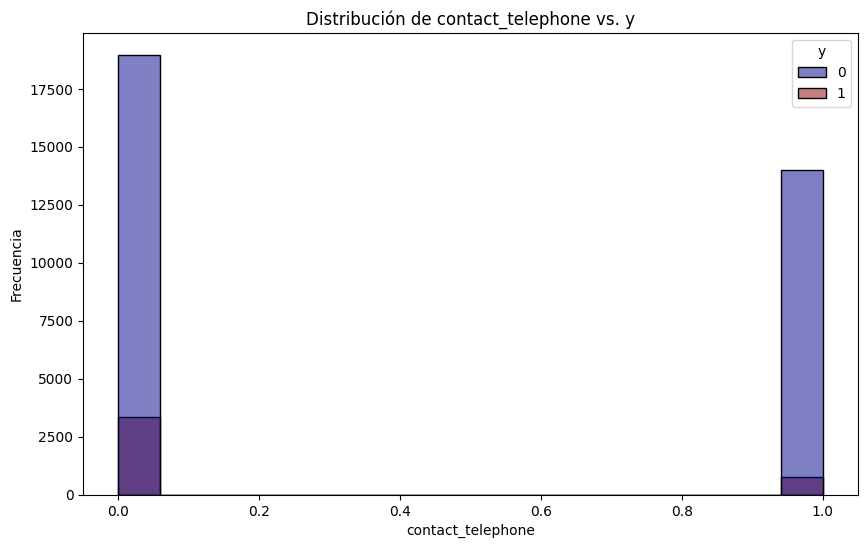

In [ ]:
correlation_with_y = correlation_matrix['y'].abs()
relevant_variables = correlation_with_y[correlation_with_y > 0.1].index.drop('y')


for variable in relevant_variables:
  plt.figure(figsize=(10, 6))


  if pd.api.types.is_numeric_dtype(encode[variable]):
    sns.histplot(x=variable, hue='y', data=encode, palette=['darkblue', 'darkred'])

  else:
    sns.countplot(x=variable, hue='y', data=encode, palette=['darkblue', 'darkred'])
  plt.title(f'Distribución de {variable} vs. y')
  plt.xlabel(variable)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
encode.dtypes.to_frame()

,0
age,int64
month,int64
day_of_week,int64
duration,int64
campaign,int64
pdays,int64
previous,int64
emp.var.rate,float64
cons.price.idx,float64
cons.conf.idx,float64


Se agregaron las columnas

1.   contactosTotales para ver cuantas veces se lo contacto previamente
2.   fueContactado para ver si antes se lo habia contactado
3. campañasExitosasprevias
4. segmento que divide los clientes segun socioeconomia (es media basica la division)
5. mesNumero pase los meses a numeros 1=enero; 2=febrero y asi
6. hay algunas que tienen log, log2, winz_log, bin que son las que modifique en base al skew

---

# Análisis Relación Variable Objetivo (Y)

relacion de variables con la variable objetivo

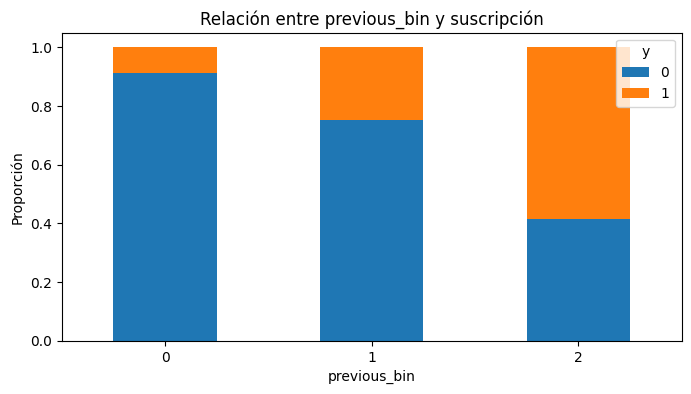

In [ ]:
#relacion con variable objetivo
for col in ['previous_bin']:
    ct = pd.crosstab(encode[col], encode['y'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f'Relación entre {col} y suscripción')
    plt.ylabel('Proporción')
    plt.xticks(rotation=0)
    plt.show()

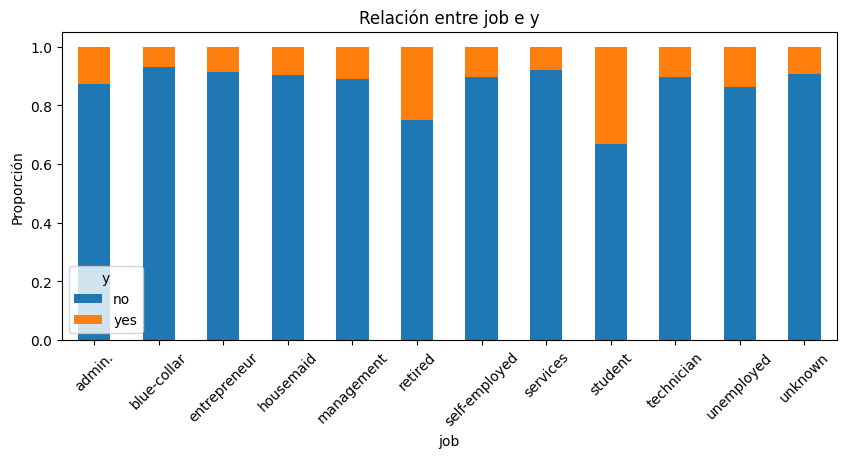

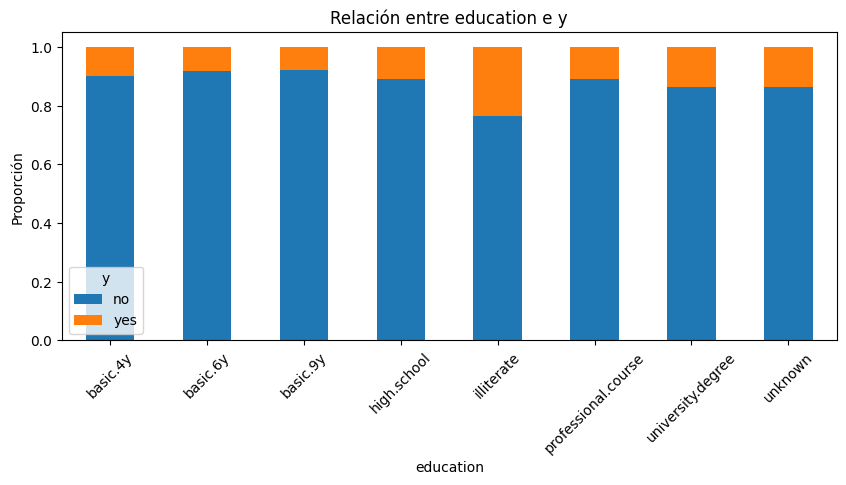

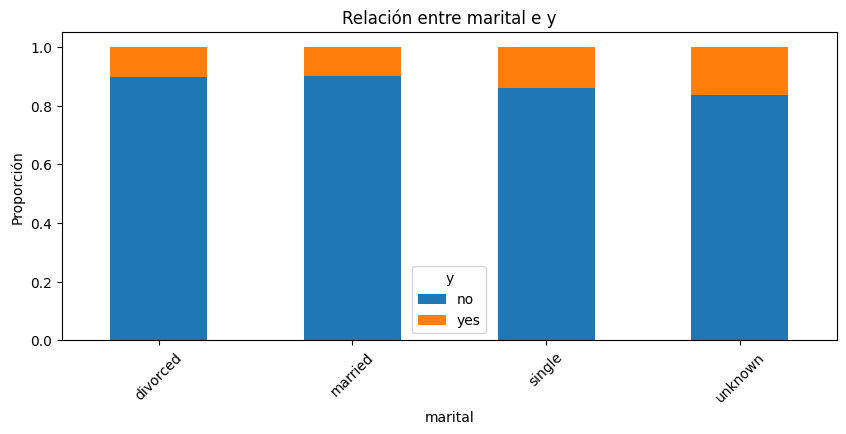

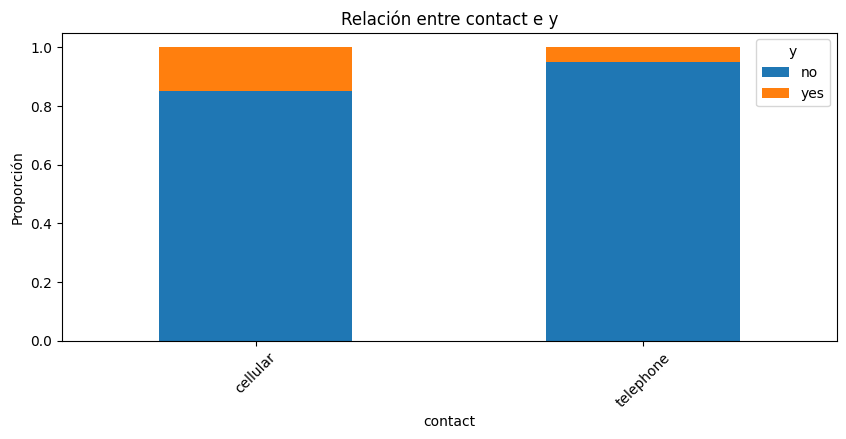

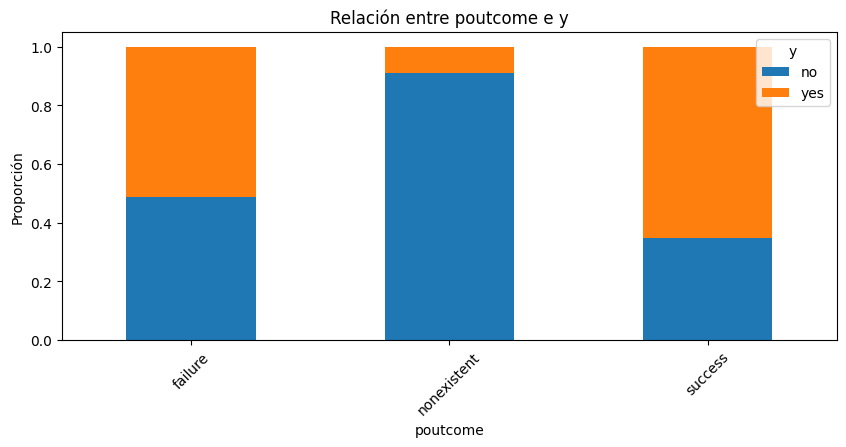

In [ ]:
for col in ['job', 'education', 'marital','contact', 'poutcome']:
    ct = pd.crosstab(data[col], data['y'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'Relación entre {col} e y')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.show()

# Pruebas de Modelo

In [ ]:
X = encode # [relevant_variables.tolist()]
encode.dtypes.to_frame()

,0
age,int64
month,int64
day_of_week,int64
duration,int64
campaign,int64
pdays,int64
previous,int64
emp.var.rate,float64
cons.price.idx,float64
cons.conf.idx,float64


In [ ]:
X = encode.drop('y', axis=1)
X = encode[relevant_variables.tolist()]
y = encode['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {"n_estimators":1000, "max_depth":15, "random_state":42}
rf_model = RandomForestClassifier(**params)


rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)
y_prob = rf_model.predict_proba(X_test)[:, 1]
metricas = {
            "accuracy": accuracy_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "accuracy_train": accuracy_score(y_train, y_pred_train),
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
mlflow.set_experiment("Experiment003")
mlflow.set_tracking_uri("http://0.0.0.0:5000")
with mlflow.start_run(run_name= "Random_Forest"):
    mlflow.log_params(params)
    mlflow.log_metrics(metricas)
    mlflow.sklearn.log_model(rf_model, "Random_Forest")
resultados_dir = "/workspaces/deteccion_clientes_banco/models/resultados"  
os.makedirs(resultados_dir, exist_ok=True)
metrics_file = os.path.join(resultados_dir, "metrics.csv")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
registro = pd.DataFrame([{
        "timestamp": timestamp,
        "modelo": "Random Forest con Random Oversampling",
        "accuracy": round(metricas['accuracy'], 4),
        "recall": round(metricas['recall'], 4),
        "precision": round(metricas['precision'], 4),
        "f1": round(metricas['f1'], 4),
        "accuracy_train": round(metricas['accuracy_train'], 4),
        "roc_auc": round(metricas['roc_auc'], 4)
    }])
if os.path.exists(metrics_file):
    registro.to_csv(metrics_file, mode="a", header=False, index=False)
else:
    registro.to_csv(metrics_file, index=False)

print(f"Métricas guardadas en {metrics_file}")


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")

Accuracy: 0.9124865156418555
Sensitivity: 0.5506257110352674
Specificity: 0.9611442557748202
Precision: 0.6558265582655827


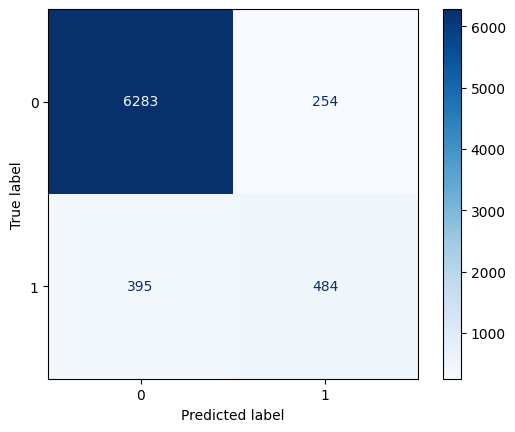

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [ ]:
# F1-score macro (promedio de clases)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

F1 macro: 0.7748

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6537
           1       0.66      0.55      0.60       879

    accuracy                           0.91      7416
   macro avg       0.80      0.76      0.77      7416
weighted avg       0.91      0.91      0.91      7416



## prueba de modelo con random sampling

In [ ]:
X = encode
X_yes = X[X['y'] == 1]
X_no = X[X['y'] == 0].sample(n=len(X_yes), random_state=42)
X_balanced = pd.concat([X_yes, X_no])
y_balanced = X_balanced['y']
X_balanced = X_balanced.drop('y', axis=1)
X_balanced = X_balanced[relevant_variables.tolist()]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

params = {"n_estimators":1000, "max_depth":10, "random_state":42}
rf_model = RandomForestClassifier(**params)


rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)
y_prob = rf_model.predict_proba(X_test)[:, 1]
metricas = {
            "accuracy": accuracy_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "accuracy_train": accuracy_score(y_train, y_pred_train),
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
with mlflow.start_run(run_name= "Random_Forest_random_oversampling"):
    mlflow.log_params(params)
    mlflow.log_metrics(metricas)
    mlflow.sklearn.log_model(rf_model, "Random_Forest_ros")
resultados_dir = "/workspaces/deteccion_clientes_banco/models/resultados"  
os.makedirs(resultados_dir, exist_ok=True)
metrics_file = os.path.join(resultados_dir, "metrics.csv")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
registro = pd.DataFrame([{
        "timestamp": timestamp,
        "modelo": "Random Forest con Random Oversampling",
        "accuracy": round(metricas['accuracy'], 4),
        "recall": round(metricas['recall'], 4),
        "precision": round(metricas['precision'], 4),
        "f1": round(metricas['f1'], 4),
        "accuracy_train": round(metricas['accuracy_train'], 4),
        "roc_auc": round(metricas['roc_auc'], 4)
    }])
if os.path.exists(metrics_file):
    registro.to_csv(metrics_file, mode="a", header=False, index=False)
else:
    registro.to_csv(metrics_file, index=False)

print(f"Métricas guardadas en {metrics_file}")

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")

Accuracy: 0.8953771289537713
Sensitivity: 0.9396135265700483
Specificity: 0.8504901960784313
Precision: 0.8644444444444445


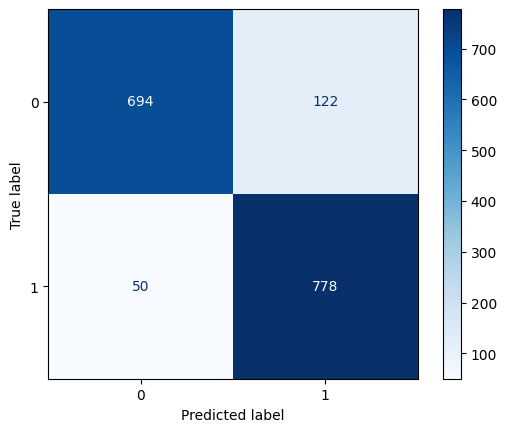

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [ ]:
# F1-score macro (promedio de clases)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

F1 macro: 0.8951

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       816
           1       0.86      0.94      0.90       828

    accuracy                           0.90      1644
   macro avg       0.90      0.90      0.90      1644
weighted avg       0.90      0.90      0.90      1644



In [ ]:
# prompt: Crea el codigo comparado el accuracy de los datos de train y tes para analizar overfitting.

# Calculate training accuracy
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {accuracy:.4f}")

# Compare accuracies
if train_accuracy > accuracy:
    print("The model might be overfitting as training accuracy is significantly higher than testing accuracy.")
elif train_accuracy < accuracy:
    print("The model might be underfitting as training accuracy is lower than testing accuracy.")
else:
    print("Training and testing accuracies are similar, suggesting a good fit.")


Training Accuracy: 0.9267
Testing Accuracy: 0.8954
The model might be overfitting as training accuracy is significantly higher than testing accuracy.


# Data augmentation


## aplicar tecnicas de oversampleo

### SMOTE

In [ ]:
x = encode
smote_df = x.copy()
smote_df_y = smote_df['y']
smote_df_x = smote_df.drop('y', axis=1)

In [ ]:
smote = SMOTE(sampling_strategy = 1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(smote_df_x, smote_df_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [ ]:
# F1-score macro (promedio de clases)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

### ADASYN

In [ ]:
x = encode
adasyn_df = x.copy()
adasyn_df_y = adasyn_df['y']
adasyn_df_x = adasyn_df.drop('y', axis=1)

In [ ]:
adasyn = ADASYN(sampling_strategy = 1, random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(adasyn_df_x, adasyn_df_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [ ]:
# F1-score macro (promedio de clases)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))